## Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Creating the sine wave dataset

In [2]:
x = np.linspace(0,50,501)
y = np.sin(x)
# plt.plot(x,y)

In [3]:
df = pd.DataFrame(data=y, index=x, columns = ['Sines'])
df.tail()

,Sines
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400
50.0,-0.262375


## Train test split the dataset

In [4]:
test_percent = 0.1
len(df)*test_percent

50.1

In [5]:
test_point = np.round(len(df)*test_percent)
test_point

50.0

In [6]:
test_index = int(len(df)-test_point)
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [7]:
print(train.shape, test.shape)

(451, 1) (50, 1)


## Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## How to Create the timestamp

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 3 # this is the time steps. Takes two points to predict the next one
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=batch_size)

In [10]:
print(len(scaled_train), len(generator))

451 448


In [11]:
scaled_train[:5]

array([[0.49999912],
       [0.54991622],
       [0.59933458],
       [0.64776041],
       [0.69470985]])

In [12]:
X,y = generator[0]
print(X)
print("--------------")
print(y)

[[[0.49999912]
  [0.54991622]
  [0.59933458]]]
--------------
[[0.64776041]]


## Time stamp for RNN

In [13]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
length = 50 # this is the time steps. Takes two points to predict the next one
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=batch_size)

## Modeling 

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

In [15]:
n_features=1
model = Sequential()
model.add(SimpleRNN(50, input_shape=(length,n_features)))
# model.add(SimpleRNN(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [16]:
model.fit(generator, epochs=10)

Epoch 1/10
401/401 [==============================] - 3s 6ms/step - loss: 0.0109
Epoch 2/10
401/401 [==============================] - 2s 5ms/step - loss: 2.6828e-04
Epoch 3/10
401/401 [==============================] - 2s 5ms/step - loss: 5.9567e-05
Epoch 4/10
401/401 [==============================] - 2s 5ms/step - loss: 7.3065e-04
Epoch 5/10
401/401 [==============================] - 2s 5ms/step - loss: 2.7916e-05
Epoch 6/10
401/401 [==============================] - 2s 5ms/step - loss: 2.8418e-05
Epoch 7/10
401/401 [==============================] - 2s 5ms/step - loss: 1.7659e-04
Epoch 8/10
401/401 [==============================] - 2s 5ms/step - loss: 2.8386e-05
Epoch 9/10
401/401 [==============================] - 2s 5ms/step - loss: 1.1321e-05
Epoch 10/10
401/401 [==============================] - 2s 5ms/step - loss: 1.1762e-04


<AxesSubplot:>

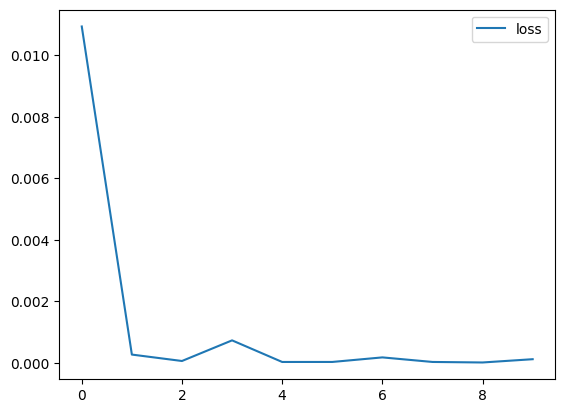

In [17]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Performance evaluation

In [18]:
first_eval_batch = scaled_train[-length:]

In [19]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [20]:
# model.predict(first_eval_batch)

In [21]:
scaled_test[0][0]

0.9495513437783747

In [22]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))  

for i in range(len(test)):
    current_pred = model.predict(current_batch, verbose=1)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 19ms/step


In [23]:
true_predictions = scaler.inverse_transform(test_predictions)

In [33]:
# plt.plot(scaled_test)
# plt.plot(test_predictions)

In [25]:
test['Predictions'] = true_predictions

C:\Users\younu\AppData\Local\Temp\ipykernel_9876\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:>

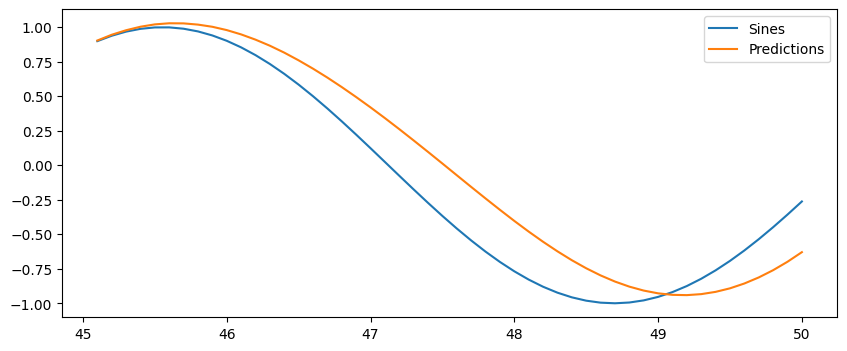

In [26]:
test.plot(figsize = (10,4))

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [28]:
length = 30

generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=batch_size)
val_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                length=length, batch_size=batch_size)

In [29]:
model = Sequential()
model.add(LSTM(50, input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [30]:
model.fit(generator, validation_data=val_generator, epochs=20)

Epoch 1/20
421/421 [==============================] - 6s 10ms/step - loss: 0.0117 - val_loss: 1.8287e-04
Epoch 2/20
421/421 [==============================] - 4s 9ms/step - loss: 1.7418e-04 - val_loss: 9.8894e-04
Epoch 3/20
421/421 [==============================] - 4s 9ms/step - loss: 1.8320e-04 - val_loss: 2.8806e-05
Epoch 4/20
421/421 [==============================] - 4s 9ms/step - loss: 6.4371e-05 - val_loss: 3.5839e-05
Epoch 5/20
421/421 [==============================] - 3s 8ms/step - loss: 7.1653e-05 - val_loss: 4.8962e-05
Epoch 6/20
421/421 [==============================] - 4s 8ms/step - loss: 7.0658e-04 - val_loss: 0.0018
Epoch 7/20
421/421 [==============================] - 4s 9ms/step - loss: 9.7491e-05 - val_loss: 1.7884e-05
Epoch 8/20
421/421 [==============================] - 4s 9ms/step - loss: 3.6951e-05 - val_loss: 3.7555e-06
Epoch 9/20
421/421 [==============================] - 4s 9ms/step - loss: 4.6430e-05 - val_loss: 2.8081e-05
Epoch 10/20
421/421 [==============

In [31]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))  

for i in range(len(test)):
    current_pred = model.predict(current_batch, verbose=1)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions_lstm'] = true_predictions


1/1 [==============================] - 0s 21ms/step


C:\Users\younu\AppData\Local\Temp\ipykernel_9876\1853416923.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions_lstm'] = true_predictions


<AxesSubplot:>

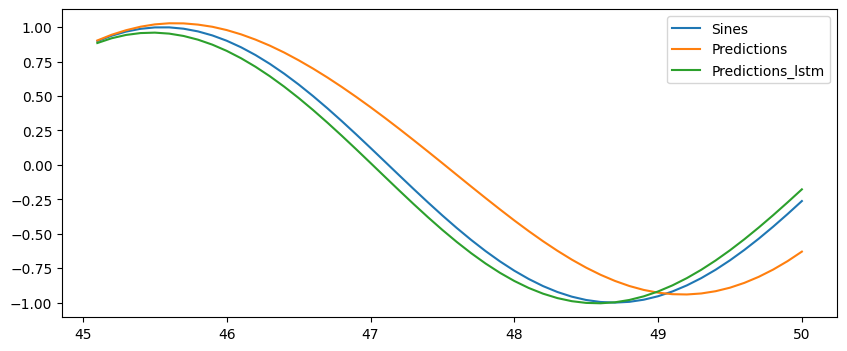

In [32]:
test.plot(figsize = (10,4))

## Train on full dataset

In [34]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [36]:
length = 30
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                                length=length, batch_size=batch_size)

In [37]:
model = Sequential()
model.add(LSTM(50, input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [38]:
model.fit(generator, epochs=10)

Epoch 1/10
471/471 [==============================] - 5s 8ms/step - loss: 0.0068
Epoch 2/10
471/471 [==============================] - 4s 8ms/step - loss: 8.3336e-05
Epoch 3/10
471/471 [==============================] - 4s 8ms/step - loss: 1.3725e-04
Epoch 4/10
471/471 [==============================] - 4s 8ms/step - loss: 2.9982e-04
Epoch 5/10
471/471 [==============================] - 4s 8ms/step - loss: 1.0323e-04
Epoch 6/10
471/471 [==============================] - 4s 8ms/step - loss: 1.5781e-04
Epoch 7/10
471/471 [==============================] - 4s 9ms/step - loss: 1.6689e-04
Epoch 8/10
471/471 [==============================] - 5s 10ms/step - loss: 5.8465e-05
Epoch 9/10
471/471 [==============================] - 5s 10ms/step - loss: 5.1092e-05
Epoch 10/10
471/471 [==============================] - 4s 9ms/step - loss: 3.5396e-04


In [50]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))  

for i in range(100):
    current_pred = model.predict(current_batch, verbose=0)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [51]:
forecast = scaler.inverse_transform(forecast)

In [60]:
forecast_index = np.arange(50.1, 60.1, step=0.1)

In [61]:
len(forecast_index), len(forecast)

(100, 100)

In [62]:
100*.1

10.0

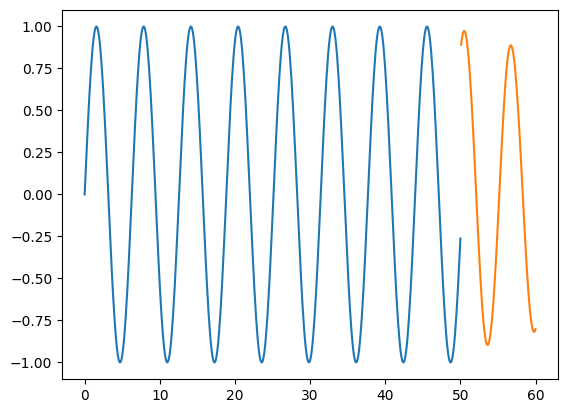

In [63]:
plt.plot(df.index, df['Sines'])
plt.plot(forecast_index, forecast)

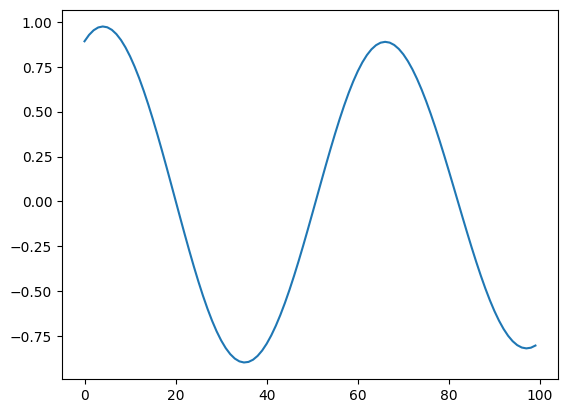

In [64]:
plt.plot(forecast)